# imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy.special import roots_legendre
import FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# model class

In [3]:
l0 = 0.0125
G_c = 1.0
E = 1.0

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.u = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50, 1)
        )
        
        self.ϕ = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50, 1)#, nn.Sigmoid()
        )
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).detach().clone().to(device) # set same initial point to both optimizers
                                                         
        self.grads = torch.zeros_like(self.start) # gradients w.r.t model parameters
        
        # Generate Gauss-Legendre points and weights
        x0, w0 = self.gauss_legendre_quadrature(-2 * l0, 2 * l0)
        x1, w1 = self.gauss_legendre_quadrature(-1, -2 * l0)
        x2, w2 = self.gauss_legendre_quadrature(2 * l0, 1)
        self.x = torch.cat([x1, x0, x2], dim=0).to(device)
        self.w = torch.cat([w1, w0, w2], dim=0).to(device)
        self.x.requires_grad = True

    def forward(self, x):
        return (x*x -1) * self.u(x), self.ϕ(x)

    def gauss_legendre_quadrature(self, a, b, n_points = 112):
        points, weights = roots_legendre(n_points)
        # Transform to [a, b]
        points = 0.5 * (points + 1) * (b - a) + a
        weights *= 0.5 * (b - a)
        return torch.tensor(points, dtype=torch.float32), torch.tensor(weights, dtype=torch.float32)

    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        # setting the network parameters
        torch.nn.utils.vector_to_parameters(param, self.parameters())

        # zeroing the gradients
        self.zero_grad()

        u, ϕ = model(inputs)
        
        ϵ = torch.autograd.grad(u, inputs, torch.ones_like(u), create_graph=True)[0]
        ϕ_x = torch.autograd.grad(ϕ, inputs, torch.ones_like(ϕ), create_graph=True)[0]
        
        ϵ_plus = torch.relu(ϵ)
        ϵ_minus = - torch.relu(-ϵ)
        ψ_plus = 0.5 * E * ϵ_plus * ϵ_plus
        ψ_minus = 0.5 * E * ϵ_minus**2
        
        H_init = torch.where(torch.abs(inputs) <= l0, 1000.0, 0.0)
        H = torch.max(H_init, ψ_plus)
        
        f_c =  + (G_c / (4*l0)) * ϕ**2 + 4*l0**2 * ϕ_x.pow(2) + (1 - ϕ)**2 * H
        f_e = + (1 - ϕ)**2 * ψ_plus + ψ_minus - torch.sin(torch.pi * inputs) * u

        if no_grad == False:        # if gradient is also required
            self.loss = ((f_e + f_c) * self.w.view(-1,1)).pow(1).sum() 
            self.loss.backward()
            
            # assemble the gradients wrt model parameters
            self.grads[:] = torch.nn.utils.parameters_to_vector([param.grad for param in self.parameters()])

            return self.loss.detach().item(), self.grads
        else:
            with torch.no_grad():
                self.loss = ((f_e + f_c) * self.w.view(-1,1)).pow(1).sum()
                return self.loss.detach().item()

# model

In [5]:
model = PINN().to(device)

In [6]:
model.start.shape[0]

36002

# train with FINDER

In [7]:
torch.nn.utils.vector_to_parameters(model.start.clone(), model.parameters())

In [8]:
FINDER1 = FINDER_core.FINDER(model = model, clamps = [0.0001,0.0001]) # optimizer is set to be of FINDER_core class

In [9]:
every = 10
tic = time.time()
fx = []
model.train()
epochs = 1000
for epoch in range(epochs):

    running_loss = FINDER1.step(inputs=model.x.view(-1,1))
    fx.append(running_loss)
    
    if (epoch) % every == 0 or epoch == epochs-1:
        print('Epoch [%d] loss: %.6f' %(epoch, running_loss))
    if running_loss < 1e-3:
        break

toc = time.time()
print("finished training in: ", toc - tic, " seconds")
runtime_FINDER = round(toc - tic)

Epoch [0] loss: 15.430585
Epoch [10] loss: 12.994073
Epoch [20] loss: 6.566875
Epoch [30] loss: 3.627502
Epoch [40] loss: 1.201298
Epoch [50] loss: 0.957041
Epoch [60] loss: 0.919776
Epoch [70] loss: 0.862262
Epoch [80] loss: 0.832523
Epoch [90] loss: 0.808181
Epoch [100] loss: 0.793285
Epoch [110] loss: 0.777577
Epoch [120] loss: 0.769215
Epoch [130] loss: 0.759007
Epoch [140] loss: 0.755203
Epoch [150] loss: 0.749978
Epoch [160] loss: 0.742296
Epoch [170] loss: 0.734792
Epoch [180] loss: 0.723828
Epoch [190] loss: 0.712536
Epoch [200] loss: 0.686547
Epoch [210] loss: 0.663285
Epoch [220] loss: 0.635478
Epoch [230] loss: 0.597831
Epoch [240] loss: 0.572527
Epoch [250] loss: 0.550451
Epoch [260] loss: 0.546345
Epoch [270] loss: 0.542725
Epoch [280] loss: 0.541217
Epoch [290] loss: 0.539835
Epoch [300] loss: 0.539118
Epoch [310] loss: 0.538536
Epoch [320] loss: 0.538121
Epoch [330] loss: 0.537994
Epoch [340] loss: 0.537417
Epoch [350] loss: 0.537139
Epoch [360] loss: 0.536493
Epoch [370

# testing

In [10]:
x = torch.linspace(-1,1, 5000).view(-1,1).to(device)
x.requires_grad_(True)
u, ϕ = model(x)

In [11]:
u_ex = torch.where(x<0, torch.sin(torch.pi * x) / torch.pi**2 - (1+x)/ torch.pi, torch.sin(torch.pi * x) / torch.pi**2 + (1-x)/ torch.pi)
ϕ_ex = torch.exp(-torch.abs(x)/(l0))

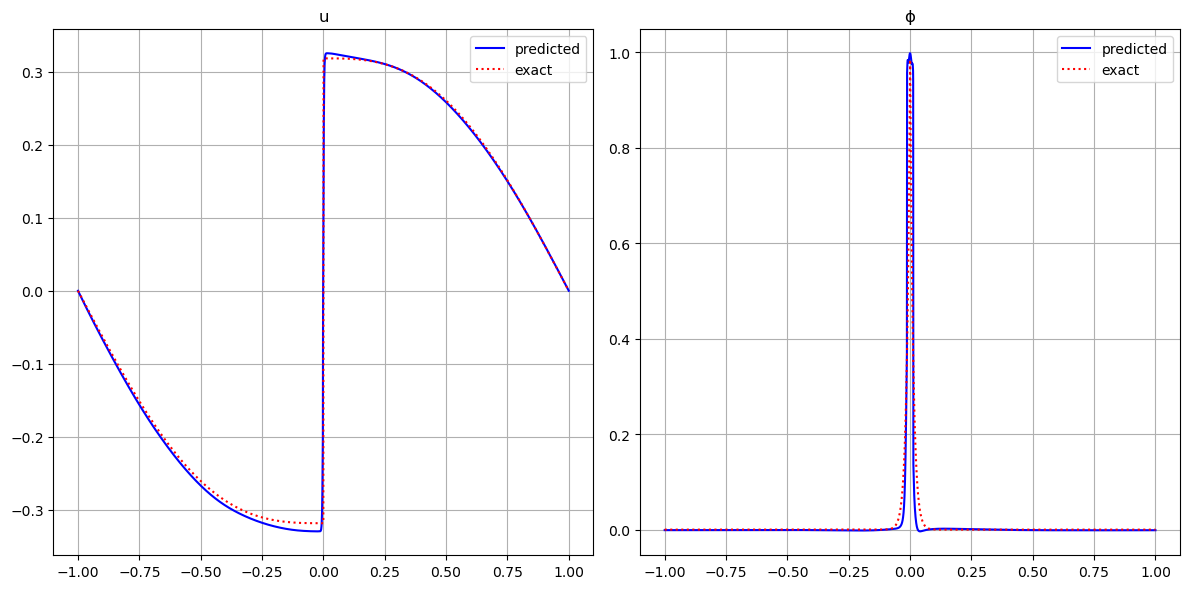

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(x.cpu().detach().numpy(), u.cpu().detach().numpy(), "b-", label = "predicted")
axs[0].plot(x.cpu().detach().numpy(), u_ex.cpu().detach().numpy(), "r:", label = "exact")
axs[0].set_title('u')
axs[0].grid()
axs[0].legend()
axs[1].plot(x.cpu().detach().numpy(), ϕ.cpu().detach().numpy(), "b-", label = "predicted")
axs[1].plot(x.cpu().detach().numpy(), ϕ_ex.cpu().detach().numpy(), "r:", label = "exact")
axs[1].set_title('ϕ')
axs[1].grid()
axs[1].legend()
plt.tight_layout()
plt.show()

# train with Adam

In [13]:
# model_adam = PINN().to(device)
torch.nn.utils.vector_to_parameters(model.start.clone(), model.parameters())
adam = torch.optim.Adam(model.parameters(), lr = 0.001)

In [14]:
every = 10
tic = time.time()
fx_adam = []
model.train()
epochs = 10000
for epoch in range(epochs):
    param = torch.nn.utils.parameters_to_vector(model.parameters()).view(-1,1)
    running_loss = model.loss_grad(param=param, inputs=model.x.view(-1,1))[0]
    adam.step()
    fx_adam.append(running_loss)
    
    if (epoch) % every == 0 or epoch == epochs-1:
        print('Epoch [%d] loss: %.6f' %(epoch, running_loss))
    if running_loss < 1e-3:
        break

toc = time.time()
runtime_adam = round(toc - tic)
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 22.870790
Epoch [10] loss: 15.771192
Epoch [20] loss: 15.312613
Epoch [30] loss: 14.848581
Epoch [40] loss: 14.084322
Epoch [50] loss: 12.467675
Epoch [60] loss: 6.934584
Epoch [70] loss: 4.706061
Epoch [80] loss: 3.203836
Epoch [90] loss: 2.028257
Epoch [100] loss: 1.364587
Epoch [110] loss: 1.072475
Epoch [120] loss: 0.939300
Epoch [130] loss: 0.896973
Epoch [140] loss: 0.962878
Epoch [150] loss: 0.902359
Epoch [160] loss: 0.897385
Epoch [170] loss: 0.882736
Epoch [180] loss: 0.878097
Epoch [190] loss: 0.875714
Epoch [200] loss: 0.873621
Epoch [210] loss: 0.871828
Epoch [220] loss: 0.870024
Epoch [230] loss: 0.868411
Epoch [240] loss: 0.866835
Epoch [250] loss: 0.865319
Epoch [260] loss: 0.863844
Epoch [270] loss: 0.862391
Epoch [280] loss: 0.860946
Epoch [290] loss: 0.859482
Epoch [300] loss: 0.857964
Epoch [310] loss: 0.856339
Epoch [320] loss: 0.854550
Epoch [330] loss: 0.852658
Epoch [340] loss: 0.850771
Epoch [350] loss: 0.847862
Epoch [360] loss: 0.844537
Epoch 

# train with LBFGS

In [15]:
lbfgs = torch.optim.LBFGS(model.parameters(), lr = 1.0, line_search_fn="strong_wolfe")
torch.nn.utils.vector_to_parameters(model.start.clone(),model.parameters())

In [16]:
def closure():
    model.zero_grad()
    inputs = model.x.view(-1,1)
    u, ϕ = model(inputs)
    # u_m = (inputs**2 - 1) * u
    ϵ = torch.autograd.grad(u, inputs, torch.ones_like(u), create_graph=True)[0]#[:,0:1]
    ϕ_x = torch.autograd.grad(ϕ, inputs, torch.ones_like(ϕ), create_graph=True)[0]#[:,0:1]

    ϵ_plus = torch.relu(ϵ)
    ϵ_minus = - torch.relu(-ϵ)
    ψ_plus = 0.5 * E * ϵ_plus * ϵ_plus
    ψ_minus = 0.5 * E * ϵ_minus**2
    
    H_init = torch.where(torch.abs(inputs) <= l0, 1000.0, 0.0)
    H = torch.max(H_init, ψ_plus)
    
    f_c =  + (G_c / (4*l0)) * ϕ**2 + 4*l0**2 * ϕ_x.pow(2) + (1 - ϕ)**2 * H
    f_e = + (1 - ϕ)**2 * ψ_plus + ψ_minus - torch.sin(torch.pi * inputs) * u
    
    loss = ((f_e + f_c) * model.w.view(-1,1)).pow(1).sum() 
    loss.backward()
    
    return loss

In [17]:
every = 10
tic = time.time()
fx_lbfgs = []
model.train()
epochs = 1000
for epoch in range(epochs):
    
    running_loss = lbfgs.step(closure=closure)
    
    fx_lbfgs.append(running_loss.item())
    
    if (epoch) % every == 0 or epoch == epochs-1:
        print('Epoch [%d] loss: %.6f' %(epoch, running_loss))
    if running_loss < 1e-3:
        break

toc = time.time()
runtime_lbfgs = round(toc-tic)
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 22.870790
Epoch [10] loss: 0.773124
Epoch [20] loss: 0.656406
Epoch [30] loss: 0.650911
Epoch [40] loss: 0.649332
Epoch [50] loss: 0.648105
Epoch [60] loss: 0.648067
Epoch [70] loss: 0.648067
Epoch [80] loss: 0.648067
Epoch [90] loss: 0.648067
Epoch [100] loss: 0.648067
Epoch [110] loss: 0.648067
Epoch [120] loss: 0.648067
Epoch [130] loss: 0.648067
Epoch [140] loss: 0.648067
Epoch [150] loss: 0.648067
Epoch [160] loss: 0.648067
Epoch [170] loss: 0.648067
Epoch [180] loss: 0.648067
Epoch [190] loss: 0.648067
Epoch [200] loss: 0.648067
Epoch [210] loss: 0.648067
Epoch [220] loss: 0.648067
Epoch [230] loss: 0.648067
Epoch [240] loss: 0.648067
Epoch [250] loss: 0.648067
Epoch [260] loss: 0.648067
Epoch [270] loss: 0.648067
Epoch [280] loss: 0.648067
Epoch [290] loss: 0.648067
Epoch [300] loss: 0.648067
Epoch [310] loss: 0.648067
Epoch [320] loss: 0.648067
Epoch [330] loss: 0.648067
Epoch [340] loss: 0.648067
Epoch [350] loss: 0.648067
Epoch [360] loss: 0.648067
Epoch [370]

# plotting

In [19]:
fx.insert(0,fx_adam[0])

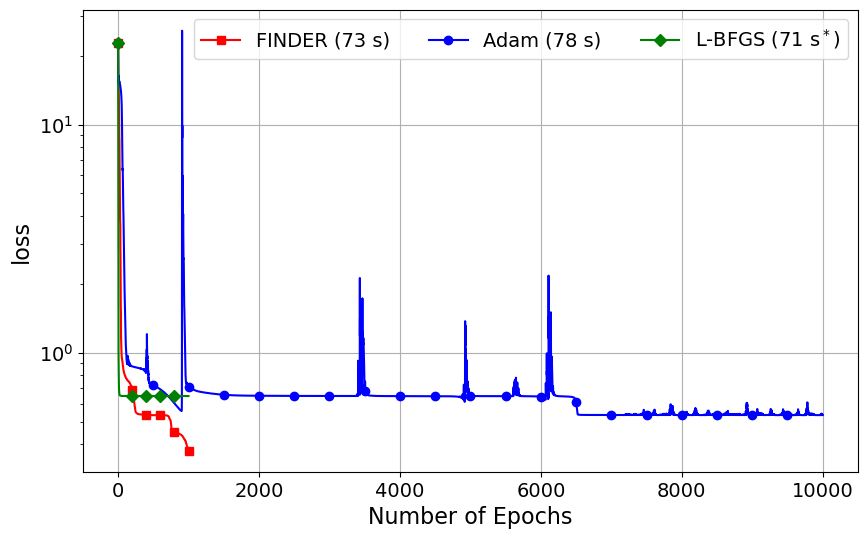

In [22]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fx, 'rs-', markevery= 200, label=f"FINDER ({runtime_FINDER} s)")
plt.plot(fx_adam, 'bo-', markevery= 500, label=f"Adam ({runtime_adam} s)")
plt.plot(fx_lbfgs, 'gD-', markevery= 200, label=f"L-BFGS ({runtime_lbfgs} s$^*$)")

plt.ylabel('loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.legend(loc="best", ncol=3, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()